# Modelado en Optimización (IIND-2501)

## Lección 3.1.1: Búsqueda del mínimo o máximo de una función no lineal

In [1]:
import numpy as np, matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)
np.set_printoptions(precision=4, suppress=True)

El primer problema de optimización que veremos es la minimización (o maximización) de una función no lineal con variables continuas, sin considerar restricciones. Este es un caso **diferente al de los Módulos 1 y 2 del curso**, en los que sí considerábamos retricciones y las funciones objetivo eran lineales. Muchos problemas prácticos requieren encontrar el óptimo de una función no lineal, así que partiremos de este caso para luego incorporar casos con restricciones y con variables enteras o binarias.

![FuncionNoLineal](assets/figs/fnolin.jpg "")

Estudiaremos dos tipos de estrategias de solución, construyendo la búsqueda iterativa con base en la ecuación de actualización:

$$x_{t+1} = x_t + \alpha \Delta x$$

1. Búsqueda local (basada en vecindarios)
    - Vecindario **cuadrado**: partiendo de un punto inicial $x_0$ consideraremos movimientos cuya dirección y longitud están dados por los extremos de un cuadrado de lado $d$ centrado en $x_0$
    - Vecindario **circular**: partiendo de un punto inicial $x_0$ consideraremos movimientos cuya dirección y longitud están dados por los extremos de un círculo de diámetro $d$ centrado en $x_0$
2. Descenso de gradiente: partiendo de un punto inicial $x_0$ consideraremos movimientos cuya dirección está dada por el gradiente negativo de la función objetivo ($-\nabla f$) y la longitud obedece a diferentes reglas


In [2]:
# ------------------------- ALGORITMOS ---------------------------
def gradient_descent(x0, grad, alpha=0.2, iters=50, eps=1e-6):
    """GD multidimensional con parada por norma del gradiente."""
    xs = [x0.copy()]; f_hist = []
    x = x0.copy()
    for _ in range(iters):
        g = grad(x)
        f_hist.append(None)   # se llenará fuera
        if np.linalg.norm(g) < eps: break
        x -= alpha * g
        xs.append(x.copy())
    return np.array(xs)

def neighbor_plus(x, step):
    """Devuelve lista de vecinos 4-direcciones en 2-D."""
    dirs = np.array([[step,0],[-step,0],[0,step],[0,-step]])
    return [x + d for d in dirs]

def local_search(x0, f, step=0.2, iters=50):
    """Búsqueda de mejor vecino (+-) con parada si no mejora."""
    xs = [x0.copy()]
    x = x0.copy()
    for _ in range(iters):
        nxt = min(neighbor_plus(x, step), key=f)
        if f(nxt) < f(x): 
            x = nxt; xs.append(x.copy())
        else:
            break
    return np.array(xs)

In [3]:
# -------------------------  PLOTEOS ------------------------------
def plot_1d_paths(func, paths_dict, xlim=(-5,5)):
    xs_curve = np.linspace(*xlim, 400)
    plt.plot(xs_curve, func(xs_curve), color="lightgray", lw=2, label="$f(x)$")
    markers = ["o", "x", "^", "s"]
    for i, (lbl, path) in enumerate(paths_dict.items()):
        path = np.array(path)
        plt.plot(path, func(path), lw=1.2, marker=markers[i], label=lbl)
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.title("Trayectorias 1-D"); plt.legend(); plt.grid(alpha=.3); plt.show()

def plot_convergence(hist_dict):
    for lbl, fvals in hist_dict.items():
        fvals = np.maximum(fvals, 1e-15)
        plt.plot(fvals, label=lbl)
    plt.yscale("log"); plt.xlabel("Iter"); plt.ylabel("f")
    plt.title("Convergencia log-scale"); plt.legend(); plt.grid(alpha=.3); plt.show()

def plot_2d_contour(func, paths_dict, span=((-2,2),(-2,2))):
    gx = np.linspace(*span[0], 200)
    gy = np.linspace(*span[1], 200)
    X,Y = np.meshgrid(gx, gy)
    Z = func((X,Y))
    plt.contour(X, Y, Z, levels=25, cmap="gray", alpha=.5)
    markers = ["o", "x", "^", "s"]
    for i,(lbl,path) in enumerate(paths_dict.items()):
        path = np.array(path)
        plt.plot(path[:,0], path[:,1], marker=markers[i], ms=4, label=lbl)
    plt.legend(); plt.gca().set_aspect("equal")
    plt.title("Trayectorias en plano x-y"); plt.show()

### 1 - Recordar la minimización de funciones derivables

En una función derivable, los puntos en los que la derivada se hace cero corresponden a máximos o mínimos (que pueden ser simplemente *óptimos locales*). Utilizaremos el caso trivial de una función cuadrática en una dimensión ($y = x^2$) para comparar dos estrategias de búsqueda, partiendo de un punto arbitrario $x_0$:

1. Evaluar puntos vecinos de $x_t$ y movernos al que muestre una mejor función objetivo (según se requiera minimizar o maximizar)
2. Calcular el gradiente *negativo* de la función (i.e., $-2x$) evaluado en $x_t$ y movernos en esa dirección

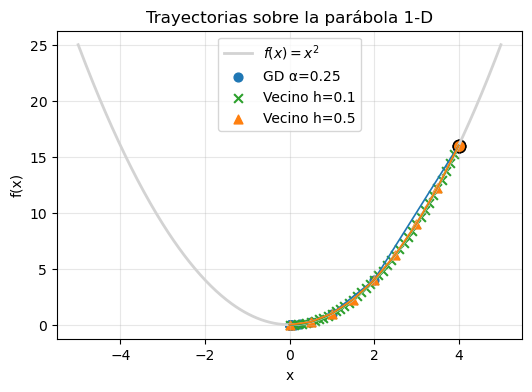

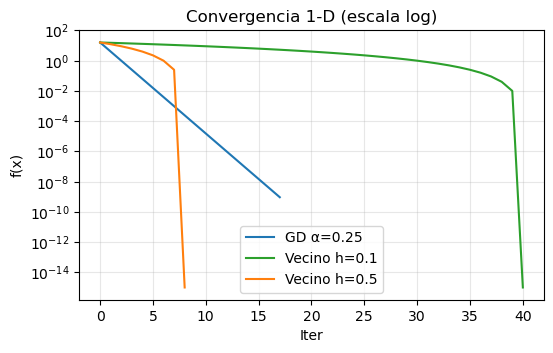

In [4]:
# ---- función y gradiente 1-D ----
f1d  = lambda x: x**2
df1d = lambda x: 2*x

# ---- Algoritmos ----
def gd_1d(x0, alpha=0.25, iters=50, eps=1e-4):
    xs, fs = [x0], [f1d(x0)]
    x = x0
    for _ in range(iters):
        x_new = x - alpha*df1d(x)
        xs.append(x_new); fs.append(f1d(x_new))
        if abs(df1d(x_new)) < eps:           # parada si grad pequeño
            break
        x = x_new
    return xs, fs

def neighbor_1d(x0, step=0.1, iters=50):
    xs, fs = [x0], [f1d(x0)]
    x = x0
    for _ in range(iters):
        cand = x - step if f1d(x - step) < f1d(x + step) else x + step
        if f1d(cand) < f1d(x):
            x = cand
            xs.append(x); fs.append(f1d(x))
        else:
            break                     #   <<  salir si no mejora
    return xs, fs

# ---- Ejecutamos ----
x0 = 4.0
path = {
    "GD α=0.25": gd_1d(x0, alpha=0.25),
    "Vecino h=0.1": neighbor_1d(x0, step=0.1),
    "Vecino h=0.5": neighbor_1d(x0, step=0.5)
}

style = {           # color y marker unificados
    "GD α=0.25":   ("C0", "o"),
    "Vecino h=0.1":("C2", "x"),
    "Vecino h=0.5":("C1", "^")
}

# ---- Plot 1: trayectoria sobre la parábola ----
xs_curve = np.linspace(-5,5,400)
plt.plot(xs_curve, f1d(xs_curve), color="lightgray", lw=2, label="$f(x)=x^2$")

for label, (traj, _) in path.items():
    color, marker = style[label]
    traj = np.array(traj)
    plt.plot(traj, f1d(traj), lw=1.2, color=color)
    plt.scatter(traj, f1d(traj), s=40, marker=marker, color=color, label=label)
    # punto inicial resaltado
    plt.scatter(traj[0], f1d(traj[0]), s=80, color=color, edgecolor="k")

plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("Trayectorias sobre la parábola 1-D")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# ---- Plot 2: convergencia ----
plt.figure(figsize=(6,3.5))
for label, (_, fvals) in path.items():
    color, _ = style[label]
    fvals = np.maximum(fvals, 1e-15)      # evita log(0)
    plt.plot(fvals, label=label, color=color)

plt.yscale("log")
plt.xlabel("Iter"); plt.ylabel("f(x)")
plt.title("Convergencia 1-D (escala log)"); plt.legend(); plt.grid(alpha=.3)
plt.show()


### 2 - Extender métodos de búsqueda a funciones 2D y mayores dimensiones

Cuando consideramos más de una dimensión, es importante tener en cuenta que:

1. Los vecindarios se pueden definir con geometrías o reglas más elaboradas
2. La derivada pasa a ser un gradiente con las derivadas parciales sobre cada dimensión

#### Función cuadrática 
Iniciaremos evaluando nuestros algoritmos de búsqueda para la función:
$$z = x_1^2+x_2^2$$

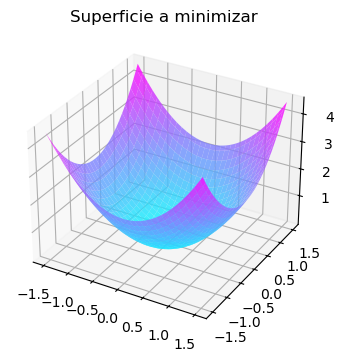

In [5]:
# ---------- define problema ----------
f_parab  = lambda X: X[0]**2 + X[1]**2
grad_par = lambda X: np.array([2*X[0], 2*X[1]])

# Surface plot para que vean el relieve
xs = ys = np.linspace(-1.5, 1.5, 60)
Xg, Yg = np.meshgrid(xs, ys)
Zg = f_parab((Xg, Yg))

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Zg, cmap='cool', alpha=0.8)
ax.set_title("Superficie a minimizar")
plt.show()

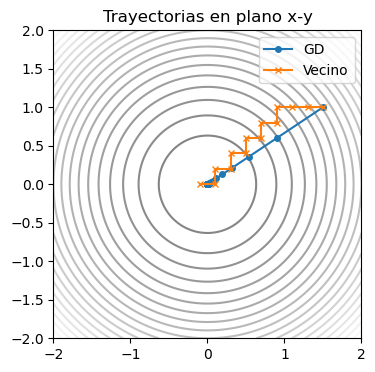

In [6]:
# ---------- corre métodos ----------
x0 = np.array([1.5, 1.0])
path_g  = gradient_descent(x0, grad_par, alpha=0.2)
path_ls = local_search   (x0, f_parab, step=0.2)

# ---------- plot ----------
plot_2d_contour(f_parab, {"GD":path_g, "Vecino":path_ls})

#### Función con múltiples picos y valles

Usaremos la función:

$$ f(x,y)=\frac{\sin(3x)\,\sin(4y)}{x^{2}+y^{2}+1} $$

como un ejemplo de una posible función compleja, cuyo mínimo global desearíamos encontrar. Construiremos funciones generales para la búsqueda con **vecindario** y con **gradiente**, y veremos su comportamiento para este ejemplo.

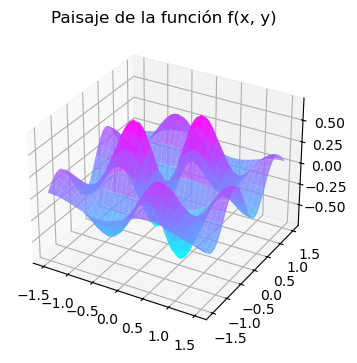

In [7]:
def f_multi(X):
    x,y = X
    return np.sin(3*x)*np.sin(4*y)/(x**2+y**2+1)
    
def grad_multi(X):
    x,y = X
    denom = x**2 + y**2 + 1
    dfdx = (3*np.cos(3*x)*np.sin(4*y))*denom - f_multi(X)*2*x
    dfdy = (4*np.sin(3*x)*np.cos(4*y))*denom - f_multi(X)*2*y
    return np.array([dfdx, dfdy]) / denom
    
# Surface plot para que vean el relieve
xs = ys = np.linspace(-1.5, 1.5, 60)
Xg, Yg = np.meshgrid(xs, ys)
Zg = f_multi((Xg, Yg))

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Zg, cmap='cool', alpha=0.8)
ax.set_title("Paisaje de la función f(x, y)")
plt.show()

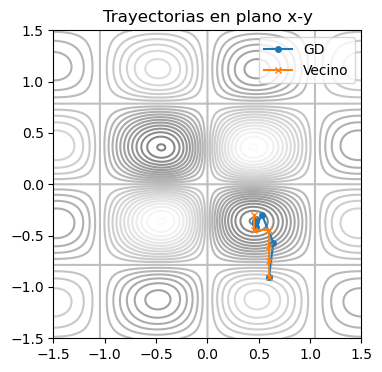

In [8]:
x0 = np.array([0.6, -0.9])
path_g2  = gradient_descent(x0, grad_multi, alpha=0.1, iters=60)
path_ls2 = local_search   (x0, f_multi, step=0.15, iters=60)

plot_2d_contour(f_multi, {"GD":path_g2, "Vecino":path_ls2}, span=((-1.5,1.5),(-1.5,1.5)))

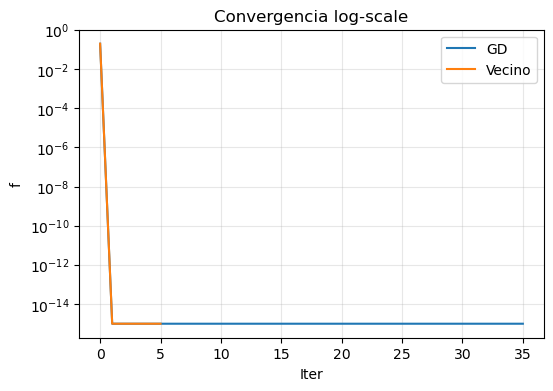

In [9]:
# Mide valor f en cada iteración
hist_g = [f_multi(p) for p in path_g2]
hist_v = [f_multi(p) for p in path_ls2]

plot_convergence({"GD":hist_g, "Vecino":hist_v})
